In [ ]:
!add-apt-repository -y ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install gcc-9 g++-9
!apt-get install gfortran-9
!apt-get install libblas-dev liblapack-dev
!apt-get install libopenblas-dev
!apt-get install scons
!apt-get install libpng-dev
!apt-get install libboost-all-dev freeglut3-dev
!apt-get install xvfb
!apt-get install libspatialindex-dev

In [ ]:
!pip install torch==1.0.1 rtree trimesh

In [ ]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 900
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-9 900

!update-alternatives --set gcc "/usr/bin/gcc-9"
!update-alternatives --set g++ "/usr/bin/g++-9"

In [ ]:
%cd /content

In [ ]:
!git clone https://github.com/mszarski/DifferentiableCloth

In [ ]:
!chmod +x DifferentiableCloth/arcsim/dependencies/taucs/configure

In [ ]:
%cd /content

In [ ]:
%cd DifferentiableCloth
%cd arcsim/dependencies/
!make -j8


In [ ]:
%cd ../..
!make -j8
%cd pysim
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes

%cd ..
%cd demo
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes

In [ ]:
##restart runtime here

In [ ]:
%cd /content/DifferentiableCloth/pysim/

/content/DifferentiableCloth/pysim


In [ ]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [48]:
%%writefile conf/double_hump_draping.json
{
    "frame_time": 0.08,
    "frame_steps": 2,
    "end_time": 10,
    "cloths": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_simplified_99pc.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,0.7]},
        "materials": [{"data": "materials/gray-interlock.json",
                      "stretching_mult":1e-3,
                      "bending_mult":1e4,
                       "thicken": 2}],
        "remeshing": {
            "refine_angle": 0.3,
            "refine_compression": 0.005,
            "refine_velocity": 0.5,
            "size": [10e-3, 100e-3],
            "aspect_min": 0.2
        }
    }
    ],
    "obstacles": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/double_hump_mm_simplified.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,-0.5]},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }
    ],
    "friction": 0.0,
    "obs_friction": 10000.0,
    "disable":["remeshing", "plasticity", "strainlimiting", "separation"],
    "gravity":[0, 0, -9.8],
    "magic": {"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}
}

Overwriting conf/double_hump_draping.json


In [ ]:
%%writefile conf/double_hump_draping.json
{
    "frame_time": 0.08,
    "frame_steps": 2,
    "end_time": 10,
    "cloths": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_simplified_99pc.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,0.7]},
        "materials": [{"data": "materials/gray-interlock.json",
                      "stretching_mult":1e-3,
                      "bending_mult":1e4,
                       "thicken": 2}],
        "remeshing": {
            "refine_angle": 0.3,
            "refine_compression": 0.005,
            "refine_velocity": 0.5,
            "size": [10e-3, 100e-3],
            "aspect_min": 0.2
        }
    }
    ],
    "friction": 0.0,
    "obs_friction": 10000.0,
    "disable":["remeshing", "plasticity", "strainlimiting", "separation"],
    "gravity":[0, 0, -9.8],
    "magic": {"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}
}

Writing conf/double_hump_draping.json


In [ ]:
import trimesh
import trimesh.transformations as tf
import numpy as np

curved_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_simplified.obj',process=False)
flat_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_simplified_99pc.obj',process=False)
scene = trimesh.Scene(base_frame='world')
curved_mesh.apply_scale(0.01)
flat_mesh.apply_scale(0.01)

transform = tf.translation_matrix([-0.1,-0.3,0.7])
flat_mesh.apply_transform(transform)
f_id = scene.add_geometry(flat_mesh)

transform = tf.translation_matrix([-0.1,-0.3,-0.5])
curved_mesh.apply_transform(transform)
c_id = scene.add_geometry(curved_mesh)

handles = [24, 2, 153, 124]
steps = 20

trajectories = []

for handle in handles:
    ray_origin = flat_mesh.vertices[handle]
    
    ray_direction = curved_mesh.vertices[handle] - flat_mesh.vertices[handle]
    ray_direction = ray_direction

    locations, index_ray, index_tri = curved_mesh.ray.intersects_location(
        ray_origins=np.array([ray_origin]),
        ray_directions=np.array([ray_direction]))

    location = locations[0]
    path = np.dstack([np.linspace(ray_origin[0],location[0],steps),np.linspace(ray_origin[1],location[1],steps),np.linspace(ray_origin[2],location[2],steps)])

    path = path.squeeze()
    trajectories.append(path)

pos_trajectories = np.array(trajectories) #this is positions, not vs
v_trajectories = np.diff(pos_trajectories,axis=1) #vs
v_trajectories = v_trajectories.transpose(1,0,2)
v_trajectories = np.concatenate([v_trajectories,np.expand_dims(np.zeros_like(v_trajectories[0]),0)])

pos_trajectories = pos_trajectories.transpose(1,0,2)
pos_trajectories = np.concatenate([pos_trajectories,np.expand_dims(np.zeros_like(pos_trajectories[0]),0)])

#scene.show()

In [ ]:
#test slide
v_trajectories[22-5][:][:,0] += 100

In [49]:
!rm -rf /content/double_hump_draping_default_out

In [50]:
import networkx as nx
import torch

torch_curved_v = torch.tensor(curved_mesh.vertices,dtype=torch.float64)

#precalculate all pairs shortest paths
G = nx.Graph()
G.add_edges_from(flat_mesh.edges_unique)
P = dict(nx.all_pairs_shortest_path(G))

def contact_front_loss_graph(sim, seed_pt_idx):
    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        dists.append(sim.cloths[0].mesh.nodes[i].x - torch_curved_v[i])

    z_dists = torch.stack(dists)[:,2]

    pos_z_dists = torch.nn.functional.relu(z_dists)
    thresh = 5e-3
    weights = torch.exp(-pos_z_dists/thresh)

    vertex_connectivity = torch.tensor(0.0,dtype=torch.float64)

    for j in range(len(sim.cloths[0].mesh.nodes)):
        vertex_connectivity += weights[P[seed_pt_idx][j]].prod()

    loss = -vertex_connectivity

    return loss

In [39]:
import math

class CosineAnnealingWarmRestarts(torch.optim.lr_scheduler._LRScheduler):
    r"""Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr, :math:`T_{cur}`
    is the number of epochs since the last restart and :math:`T_{i}` is the number
    of epochs between two warm restarts in SGDR:
    .. math::
        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1 +
        \cos\left(\frac{T_{cur}}{T_{i}}\pi\right)\right)
    When :math:`T_{cur}=T_{i}`, set :math:`\eta_t = \eta_{min}`.
    When :math:`T_{cur}=0` after restart, set :math:`\eta_t=\eta_{max}`.
    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_0 (int): Number of iterations for the first restart.
        T_mult (int, optional): A factor increases :math:`T_{i}` after a restart. Default: 1.
        eta_min (float, optional): Minimum learning rate. Default: 0.
        last_epoch (int, optional): The index of last epoch. Default: -1.
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.
    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1, verbose=False):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        self.T_0 = T_0
        self.T_i = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min

        super(CosineAnnealingWarmRestarts, self).__init__(optimizer, last_epoch)

        self.T_cur = self.last_epoch

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.T_cur / self.T_i)) / 2
                for base_lr in self.base_lrs]

    def step(self, epoch=None):
        """Step could be called after every batch update
        Example:
            >>> scheduler = CosineAnnealingWarmRestarts(optimizer, T_0, T_mult)
            >>> iters = len(dataloader)
            >>> for epoch in range(20):
            >>>     for i, sample in enumerate(dataloader):
            >>>         inputs, labels = sample['inputs'], sample['labels']
            >>>         optimizer.zero_grad()
            >>>         outputs = net(inputs)
            >>>         loss = criterion(outputs, labels)
            >>>         loss.backward()
            >>>         optimizer.step()
            >>>         scheduler.step(epoch + i / iters)
        This function can be called in an interleaved way.
        Example:
            >>> scheduler = CosineAnnealingWarmRestarts(optimizer, T_0, T_mult)
            >>> for epoch in range(20):
            >>>     scheduler.step()
            >>> scheduler.step(26)
            >>> scheduler.step() # scheduler.step(27), instead of scheduler(20)
        """

        if epoch is None and self.last_epoch < 0:
            epoch = 0

        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.T_cur = self.T_cur - self.T_i
                self.T_i = self.T_i * self.T_mult
        else:
            if epoch < 0:
                raise ValueError("Expected non-negative epoch, but got {}".format(epoch))
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
        self.last_epoch = math.floor(epoch)

        class _enable_get_lr_call:

            def __init__(self, o):
                self.o = o

            def __enter__(self):
                self.o._get_lr_called_within_step = True
                return self

            def __exit__(self, type, value, traceback):
                self.o._get_lr_called_within_step = False
                return self

        with _enable_get_lr_call(self):
            for i, data in enumerate(zip(self.optimizer.param_groups, self.get_lr())):
                param_group, lr = data
                param_group['lr'] = lr
                print(lr)
                self.print_lr(self.verbose, i, lr, epoch)

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]


In [53]:
import torch
import arcsim
import gc
import time
import json
#import sysx
import gc
import os
#import numpy as np

from datetime import datetime
now = datetime.now()
timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

out_path = '/content/double_hump_draping_default_out'

if not os.path.exists(out_path):
  os.mkdir(out_path)

with open('conf/double_hump_draping.json','r') as f:
  config = json.load(f)

def save_config(config, file):
  with open(file,'w') as f:
    json.dump(config, f)

save_config(config, out_path+'/conf.json')

torch.set_num_threads(8)
spf = config['frame_steps']
frame_time = config['frame_time']
scalev=1

##
steps = 10
trajectories = v_trajectories[:steps]
torch_pos_trajectories = torch.tensor(pos_trajectories[:steps],dtype=torch.float64)

pre_steps = 1
#epochs=10
epochs=100

boundary = [ 26,  63,  91,  62,  61, 116, 124,  93, 105,  27, 157,  78,  66,
          7, 153, 103, 129,  88, 122,  99,  89, 142, 149,  44,   6, 126,
         24,  60,  21,  11,  49, 150, 136, 139,   2,  53, 117,  36,   0]

seed_pt_idx = 83

def reset_sim(sim, epoch):
  if epoch < epochs:
    arcsim.init_physics(out_path+'/conf.json', out_path+'/out%d'%epoch,False)
  else:
    arcsim.init_physics(out_path+'/conf.json',out_path+'/out',False)

def run_sim(steps,sim,param_v):

  boundary_losses = []
  seed_pt_losses = []
  contact_losses = []
  handle_losses = []

  total_steps = (pre_steps + steps) * spf

  print("step")
  for step in range(total_steps):
    print(step)

    v_idx = step // spf - pre_steps

    if step > (pre_steps*spf)-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[v_idx,i]*scalev /spf #* spf
        #print(sim.cloths[0].mesh.nodes[handles[i]].x)
        #handle_loss += torch.norm((sim.cloths[0].mesh.nodes[handles[i]].x - torch_pos_trajectories[v_idx]))

      #print(handle_loss)
      #handle_losses.append(handle_loss)
  
      # from IPython.core.debugger import set_trace
      # set_trace()

      if step%spf == 0:
        # step_contact_loss = contact_front_loss_graph(sim, seed_pt_idx)
        # contact_losses.append(step_contact_loss)

        # step_seed_pt_loss = torch.norm((sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_curved_v[seed_pt_idx]))
        # seed_pt_losses.append(step_seed_pt_loss)

        # # loss_idxs = [*boundary]
        # loss_idxs = [*handles]
        # step_boundary_loss = torch.tensor(0.0,dtype=torch.float64)
        # for i in loss_idxs:
        #   step_boundary_loss += torch.norm(torch_curved_v[i] - sim.cloths[0].mesh.nodes[i].x, p=1)

        # boundary_losses.append(step_boundary_loss)

        handle_loss = torch.tensor(0.0,dtype=torch.float64)

        for i in range(len(handles)):
          handle_loss += torch.norm((sim.cloths[0].mesh.nodes[handles[i]].x - torch_pos_trajectories[v_idx,i]))

        handle_losses.append(handle_loss)

        #print(f"contact loss: {step_contact_loss}, seed_pt_loss: {step_seed_pt_loss}, boundary loss: {step_boundary_loss}")

    arcsim.sim_step()

  # seed_pt_loss_steps = torch.stack(seed_pt_losses,dim=0)
  # seed_pt_loss = torch.sum(seed_pt_loss_steps)

  # contact_loss_steps = torch.stack(contact_losses,dim=0)

  # growth_rates = torch.div(contact_loss_steps[1:],contact_loss_steps[:-1])
  # avg_growth_rate = torch.mean(growth_rates)
  # var_growth_rate = torch.norm(growth_rates-avg_growth_rate)**2
  # print(f"growth_rates: {growth_rates}, avg_growth_rate: {avg_growth_rate}, var_growth_rate: {var_growth_rate}")

  # for tensor in contact_loss_steps:
  #     del tensor
  # del contact_loss_steps
  # del growth_rates
  # del avg_growth_rate

  handle_loss_steps = torch.stack(handle_losses,dim=0)
  handle_loss = torch.sum(handle_loss_steps)

  for tensor in handle_loss_steps:
      del tensor
  del handle_loss_steps

  del handle_losses

  total_loss = handle_loss

  return total_loss


with open(out_path+('/log%s.txt'%timestamp),'w',buffering=1) as f:
  tot_step = 1
  sim=arcsim.get_sim()

  param_v = torch.zeros([steps, 4,3],dtype=torch.float64, requires_grad=True)

  optimizer = torch.optim.Adam([param_v],lr=5.0)

  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
  scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1.0, verbose=True)

  epoch = 0
  while True:
    reset_sim(sim, epoch)
    st = time.time()

    optimizer.zero_grad()

    loss = run_sim(steps, sim, param_v)
    en0 = time.time()

    loss.backward(retain_graph=True)

    en1 = time.time()
    print("=======================================")
    #print(param_v.data)
    #print(param_v.grad.data)
    f.write('epoch {}:  loss={} \n'.format(epoch,  loss.data))
    print('epoch {}:  loss={} \n'.format(epoch, loss.data))

    print('forward time={}'.format(en0-st))
    print('backward time={}'.format(en1-en0))

    #param_v.grad.data[:,:,2] = torch.zeros(steps,len(handles))
    #param_v.grad.data.clamp_(-25,25)

    optimizer.step()

    arcsim.delete_mesh(sim.cloths[0].mesh)
    #scheduler.step(loss.item())
    scheduler.step(epoch)

    torch.save(param_v,'param_v.pt')

    del loss

    if epoch>=epochs:
      break
    epoch = epoch + 1


print("done")


5.0
step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
growth_rates: tensor([3.4259e+08, 1.8355e+11, 3.3571e+12, 1.0537e+13, 1.6000e+13, 1.8554e+13,
        2.3738e+13, 3.6158e+00, 3.4069e-01], dtype=torch.float64,
       grad_fn=<DivBackward0>), avg_growth_rate: 8041170472868.476, var_growth_rate: 7.041421497316664e+26
epoch 0:  loss=14.4132678357942 

forward time=31.39669179916382
backward time=16.53582215309143
5.0
step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
growth_rates: tensor([3.4259e+08, 1.8355e+11, 3.3572e+12, 1.0537e+13, 1.6010e+13, 1.8604e+13,
        1.9454e+13, 9.1197e-01, 7.8305e-01], dtype=torch.float64,
       grad_fn=<DivBackward0>), avg_growth_rate: 7571792205270.371, var_growth_rate: 5.8723221142949856e+26
epoch 1:  loss=16.836769259050094 

forward time=23.930043935775757
backward time=16.69155716896057
4.902113032590307
step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
growth_rates: tensor([3.4259e+08, 1.8355e+11, 3.3571e+12, 1

KeyboardInterrupt: ignored

In [33]:
param_v.grad

tensor([[[ 7.5885e-03,  3.1491e-02, -3.6876e-03],
         [ 1.5007e-03,  3.8673e-03, -3.0999e-02],
         [ 4.0825e-03,  2.2877e-02,  2.1352e-02],
         [ 1.1603e-03,  1.2854e-02,  4.3100e-02]],

        [[ 8.5652e-03,  2.2439e-02,  1.4207e-03],
         [-1.2809e-04,  3.4167e-03,  3.3161e-03],
         [ 3.3880e-04,  1.9375e-02,  4.8364e-03],
         [ 1.4235e-03,  7.8264e-03,  1.3439e-03]],

        [[ 8.0374e-03,  1.4246e-02,  5.1402e-03],
         [-1.0582e-03,  1.2077e-03,  1.3401e-03],
         [-4.7419e-03,  9.8888e-03, -3.3393e-03],
         [ 9.1297e-04,  4.3319e-03, -4.5771e-03]],

        [[ 8.2852e-03,  2.0800e-02, -2.4877e-03],
         [-1.2059e-04,  2.8889e-03, -2.5427e-03],
         [-4.2386e-03,  1.1053e-02, -5.8891e-03],
         [ 2.4498e-04,  6.0273e-03, -2.1387e-03]],

        [[ 7.9425e-03,  1.7776e-02, -2.1736e-03],
         [-9.5356e-04,  5.6667e-04, -9.0154e-04],
         [-2.5249e-03,  1.1342e-02, -1.1517e-03],
         [ 3.9402e-04,  3.2086e-03, -3.619

In [ ]:
param_v

In [ ]:
%cd /content/DifferentiableCloth/pysim

/content/DifferentiableCloth/pysim


In [ ]:
%%writefile visualize.py
import torch
import arcsim

with torch.autograd.profiler.profile() as prof:
	  arcsim.msim(4,['arcsim','replay','/content/double_hump_draping_default_out/out', '45.0'])
print(prof)

Writing visualize.py


In [ ]:
!xvfb-run -s "-screen 0 2560x1440x24 -ac +extension GLX +render -noreset" python visualize.py

main
4
arcsim replay /content/double_hump_draping_default_out/out
reply 1 
reply 2 
reply 3 
reply 4 
reply 5 
reply 6 
/content/double_hump_draping_default_out/out/0000
reply 7 
45.0
45
/content/double_hump_draping_default_out/out/0000.png
/content/double_hump_draping_default_out/out/0001
/content/double_hump_draping_default_out/out/0001.png
/content/double_hump_draping_default_out/out/0002
/content/double_hump_draping_default_out/out/0002.png
/content/double_hump_draping_default_out/out/0003
/content/double_hump_draping_default_out/out/0003.png
/content/double_hump_draping_default_out/out/0004
/content/double_hump_draping_default_out/out/0004.png
/content/double_hump_draping_default_out/out/0005
/content/double_hump_draping_default_out/out/0005.png
/content/double_hump_draping_default_out/out/0006
/content/double_hump_draping_default_out/out/0006.png
/content/double_hump_draping_default_out/out/0007
/content/double_hump_draping_default_out/out/0007.png
/content/double_hump_draping_de

In [ ]:
import pathlib
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

frames = []
for png_file in sorted(list(pathlib.Path('/content/double_hump_draping_default_out/out').glob('*.png'))):
    frames.append(plt.imread(png_file))
    #print(bmp_file)
    

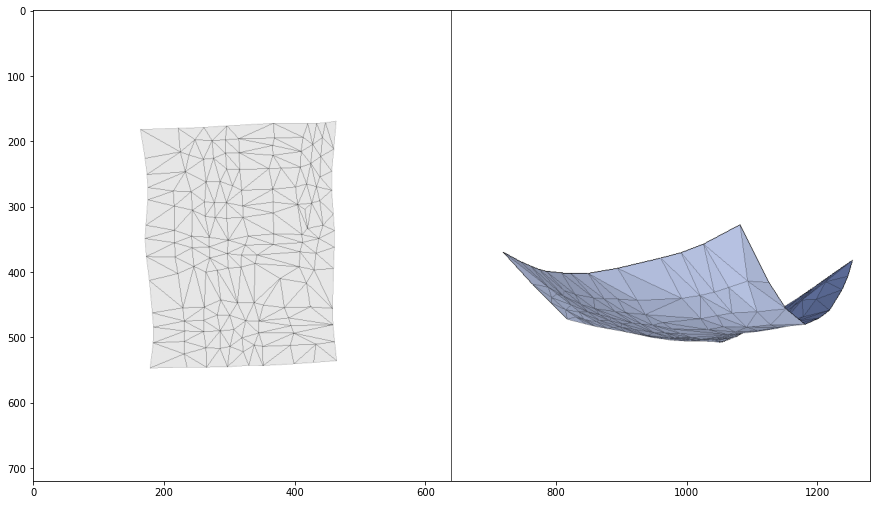

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams["figure.figsize"] = (15,15)

fig = plt.figure()

ims = []
for i in range(len(frames)):
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

In [ ]:
HTML(ani.to_html5_video())

In [ ]:
ani.save('diffdrape.mp4')

In [ ]:
torch.save(param_v, 'trajectory.pt')

In [ ]:
import trimesh
import trimesh.transformations as tf
import numpy as np

curved_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_simplified.obj',process=False)
flat_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_simplified_99pc.obj',process=False)
scene = trimesh.Scene(base_frame='world')
curved_mesh.apply_scale(0.01)
flat_mesh.apply_scale(0.01)

transform = tf.translation_matrix([-0.1,-0.3,0.7])
flat_mesh.apply_transform(transform)
f_id = scene.add_geometry(flat_mesh)

transform = tf.translation_matrix([-0.1,-0.3,-0.5])
curved_mesh.apply_transform(transform)
c_id = scene.add_geometry(curved_mesh)

handles = [24, 2, 153, 124]
steps = 20

for i in range(len(handles)):

    original_path = trimesh.load_path(np.cumsum(trajectories[:,i,:],axis=0) + + flat_mesh.vertices[handles[i]])
    optimized_path = trimesh.load_path(np.cumsum(param_v.detach().numpy()[:,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]])
    scene.add_geometry(original_path)
    scene.add_geometry(optimized_path)

scene.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection = '3d')

for i in range(len(handles)):
    trajectory = (np.cumsum(param_v.detach().numpy()[:,i,:]*0.04,axis=0) + flat_mesh.vertices[handles[i]]).T
    grad = (param_v.detach().numpy()[:,i,:]).T
    ax.plot(trajectory[0], trajectory[1], trajectory[2], marker = 'x')
    ax.quiver(trajectory[0], trajectory[1], trajectory[2], grad[0], grad[1], grad[2], length=0.5, normalize=True) #set z component to 0 to better visualize other gradients. this seems useful

plt.show()

In [ ]:
!pip install guppy3

In [ ]:
from guppy import hpy
h = hpy()
h.heap()